In [1]:
inPutDir = 'inPut/'
outPutDir = 'outPut/'

# 一、加载数据 【DocumentS_cutted.txt】

In [2]:
import pandas as pd

dataFile = inPutDir+'TimeAndCategory.txt'
f = open(dataFile,encoding='utf8')
TimeAndCategory = pd.read_table(f,sep='|')
f.close()
print(TimeAndCategory.shape)
TimeAndCategory.head()

(1137, 8)


,time,_no,_EMW,A,B,C,D,E
0,1433150298,110100,1,0,0,0,0,0
1,1435059060,110100,1,1,0,0,0,0
2,1432894713,110100,1,0,0,0,0,0
3,1478257937,230000,2,0,0,0,0,0
4,1445414025,230000,2,0,0,1,0,0


# 二、文本

- 主题词

In [3]:
def get_top_words(phi, words, num_topics, n_top_words):
    rs = []
    for t in range(len(phi)):
        one = pd.DataFrame(phi[t])
        one.columns = ['weight']
        one = one.sort_values('weight',ascending=False)
        top_n = one[:n_top_words]
        top_n['word'] = [par['word_token'][i] for i in top_n.index.values]
        rs.append(top_n[['word','weight']])
    return rs

In [4]:
import pandas as pd
import numpy as np

def get_Topic_words(par,topn):
    rs = get_top_words(par['n'], par['word_token'], par['T'], topn)
    Topic_words = pd.DataFrame(np.zeros([len(rs),topn+1]))
    for i in range(len(rs)):
        Topic_words.iloc[i,0] = ' '.join(rs[i].word)
        Topic_words.iloc[i,1:] = list(pd.DataFrame(rs[i].values).apply(lambda row: row[0]+'#'+str(float('%.6f'%row[1])),axis=1).T)
    return Topic_words

- 困惑度

In [5]:
def GetPerplexity(par):
    ##### 【main】 p(w) 
    log_P_w = []
    for d in range(par['D']):
        z_d = par['m'][d] # 文档d 各主题的概率
        w_z = []
        for i in range(par['N'][d]):
            word_di = par['w'][d][i] # 文档d中第i个词的词ID
            w_z.append(par['n'][:,word_di]) # 各主题下该词出现的概率
        P_w = np.matrix(z_d)*np.matrix(w_z).T
        log_P_w.append(np.log(P_w.sum()))
    ##### Perplexity
    Numerator = sum(log_P_w)
    Denominator = sum(par['N'])
    Perplexity = np.exp(-(Numerator/Denominator))
    
    return Perplexity

# 三、可视化

In [6]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

zhfont1 = matplotlib.font_manager.FontProperties(fname='C:\Windows\Fonts\simsun.ttc')

##### 1、主题

In [7]:
def VisualizeTopics(phi, words, num_topics, viz_threshold, needSave, outputPath, filename):		# 可视化主题
    phi_viz = np.transpose(phi) # phi[num_topics,10038] phi_viz[10038,num_topics]
    words_to_display = ~np.all(phi_viz <= viz_threshold, axis=1)
#     print(words_to_display.size)
    words_viz = [words[i] for i in range(len(words_to_display)) if words_to_display[i]]
#     print(words_viz)
    phi_viz = phi_viz[words_to_display]

    fig, ax = plt.subplots()
    heatmap = plt.pcolor(phi_viz, cmap=plt.cm.Blues, alpha=0.8)
    plt.colorbar()

    fig.set_size_inches(11,8)
    ax.grid(False)
    ax.set_frame_on(False)

    ax.set_xticks(np.arange(phi_viz.shape[1]) + 0.5, minor=False)
    ax.set_yticks(np.arange(phi_viz.shape[0]) + 0.5, minor=False)
    ax.invert_yaxis()
    ax.xaxis.tick_top()
    plt.xticks(rotation=45)

    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    column_labels = words_viz	#['Word ' + str(i) for i in range(1,1000)]
    row_labels = ['Topic ' + str(i) for i in range(1,num_topics+1)]
    ax.set_xticklabels(row_labels, minor=False)
    ax.set_yticklabels(column_labels, minor=False,fontproperties=zhfont1)
    

    ax.set_title(filename,fontproperties=zhfont1) 
    if needSave:
        plt.savefig(outputPath+filename)
    plt.show()

##### 2、进化
- 贝塔分布 https://baike.baidu.com/item/贝塔分布/8994021?fr=aladdin

In [8]:
import math
import scipy.special

def VisualizeEvolution2(psi, needSave):		# 可视化进化   
    
    K = len(psi)
    n = K//5
    ylim = 10
    fig, axes = plt.subplots(1, n, figsize=(13*n,8*1))
    axs = axes.ravel()  
    
    xs = np.linspace(0, 1, num=1000)
    
    for i in range(n):
        ax = axs[i]               
        for j in range(5):
            ii = i*5+j
#             ys = [math.pow(1-x, psi[ii][0]-1) * math.pow(x, psi[ii][1]-1) / scipy.special.beta(psi[ii][0],psi[ii][1]) for x in xs]
            ys = [math.pow(x, psi[ii][0]-1) * math.pow(1-x, psi[ii][1]-1) / scipy.special.beta(psi[ii][0],psi[ii][1]) for x in xs]
            ax.plot(xs, ys, label='Topic ' + str(ii+1))
        imgName = 'TOT_主题_进化_'+str(K)
        ax.set_title(imgName,fontproperties=zhfont1)
    #     https://github.com/wizardforcel/matplotlib-user-guide-zh/blob/master/3.6.md
        ax.legend(bbox_to_anchor=(1.025, 1),loc=2,borderaxespad=0.)
        ax.set_ylim(0, ylim)

    if needSave:
        plt.savefig(imgName)
    plt.show()

##### 3、主题强度随时间的变化

In [9]:
# 可视化主题强度随时间的变化 基于年平均主题强度
def VisualizeTime2(time_DF,needSave_png,outputPath,filename):
    K = time_DF.iloc[:,:-1].shape[1]
    n = K//5
    ylim = time_DF.iloc[:,:-1].values.max()
    fig, axes = plt.subplots(1, n+1, figsize=(13*(n+1),8*1))
    axs = axes.ravel()  
    
    x = range(len(time_DF.index.values))
    
    ax1 = axs[0]
    y = time_DF.iloc[:,-1].values
#     ax1.plot(x, y, label='Topics_dispersion')
    ax1.plot(x, y)
    ax1.set_title('主题强度方差',fontproperties=zhfont1) 
#     ax1.legend(bbox_to_anchor=(1.025, 1),loc=2, borderaxespad=0.)  
    ax1.set_xticks(x)
      
    for i in range(n):
        ax2 = axs[i+1]
        data_DF = time_DF.iloc[:,i*5:(i+1)*5]        
        for j in range(data_DF.shape[1]):
            y = data_DF.iloc[:,j].values
            ax2.plot(x, y, label='Topic ' + str(i*5+j+1))
        ax2.set_title('主题强度',fontproperties=zhfont1) 
    #     https://github.com/wizardforcel/matplotlib-user-guide-zh/blob/master/3.6.md
        ax2.legend(bbox_to_anchor=(1.025, 1),loc=2,borderaxespad=0.)
        ax2.set_ylim(0, ylim)
        ax2.set_xticks(x)

    if needSave_png:
        plt.savefig(outputPath+filename)
    plt.show()

outPut/ZC_agro_Topics.xlsx  创建成功
【T=10】 长白山


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


【T=10】 perplexity = 1.00627563929
outPut/Topic_10\  创建成功


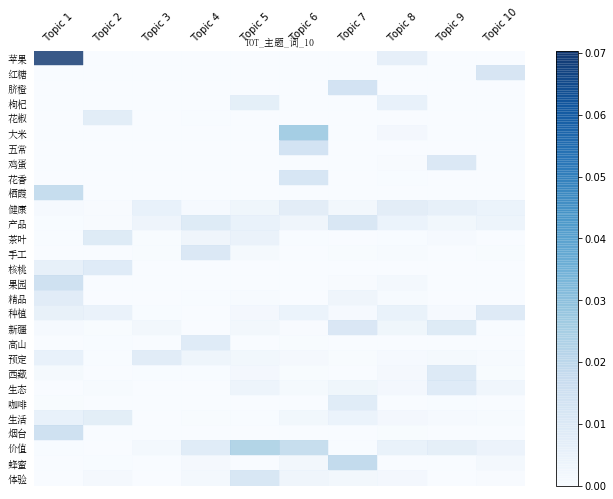

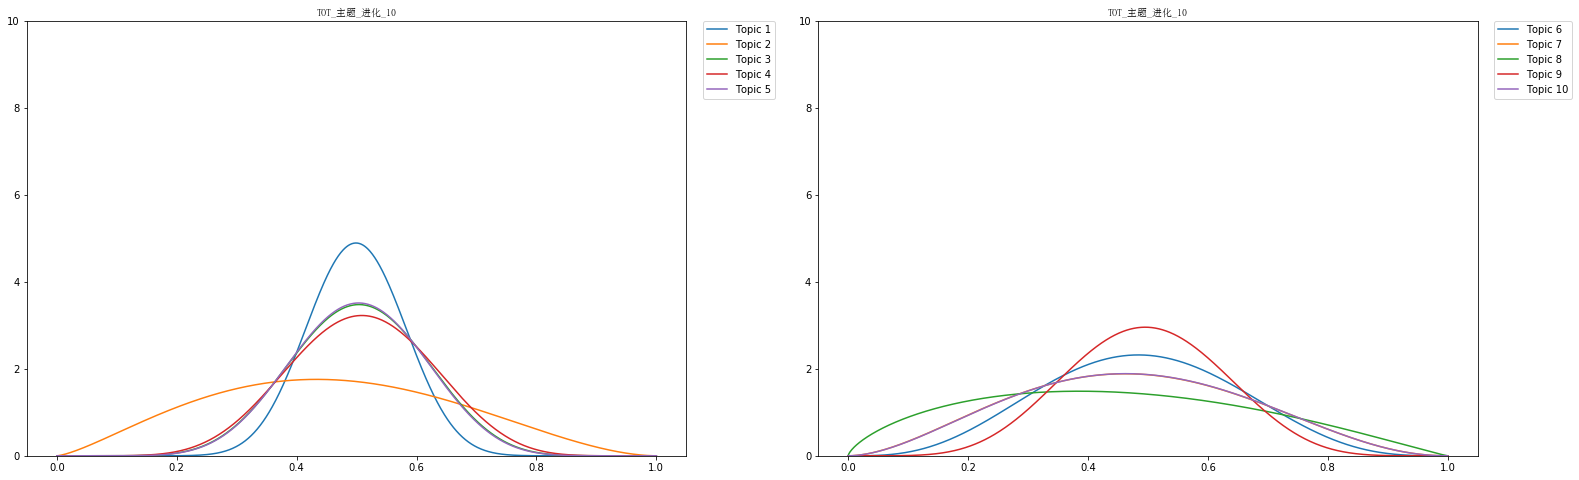

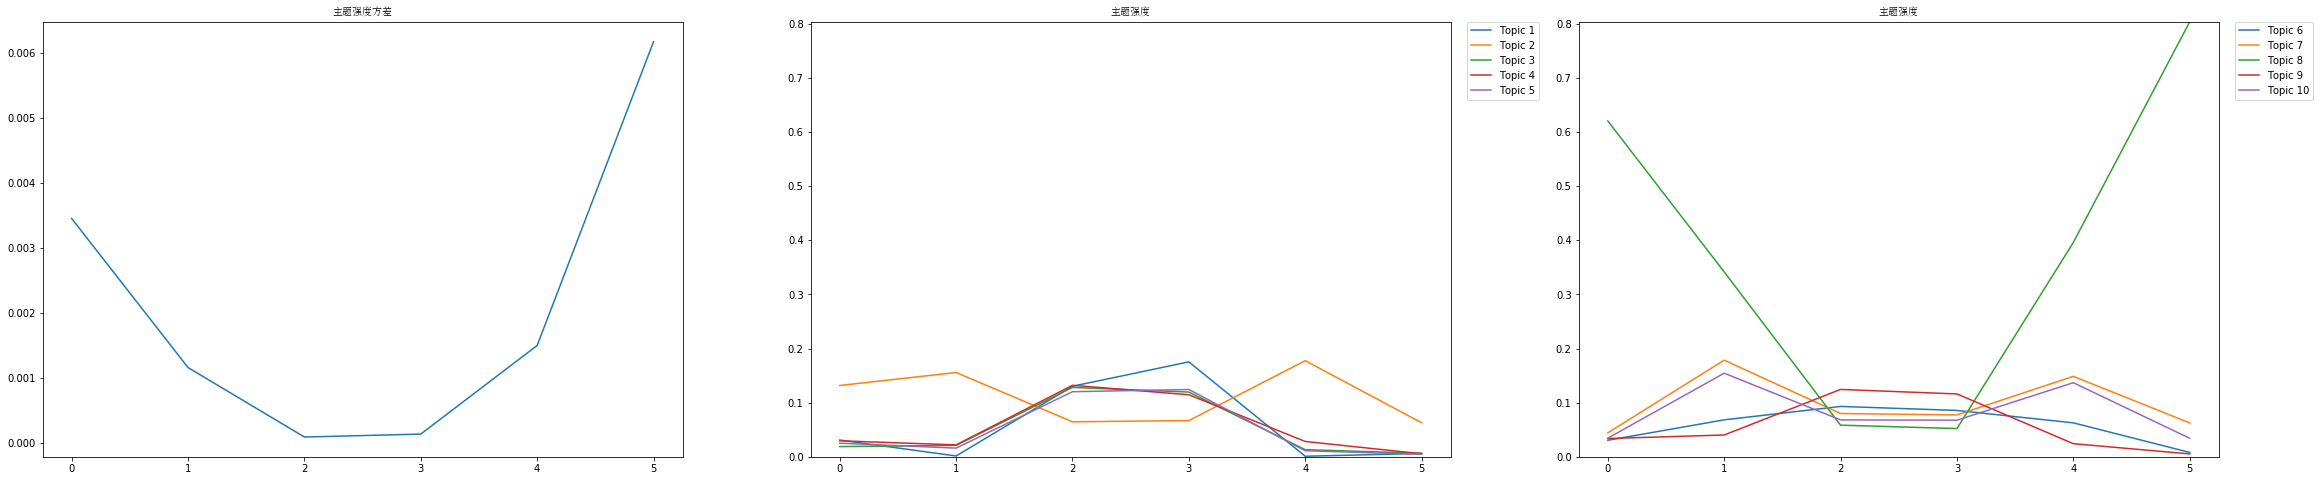

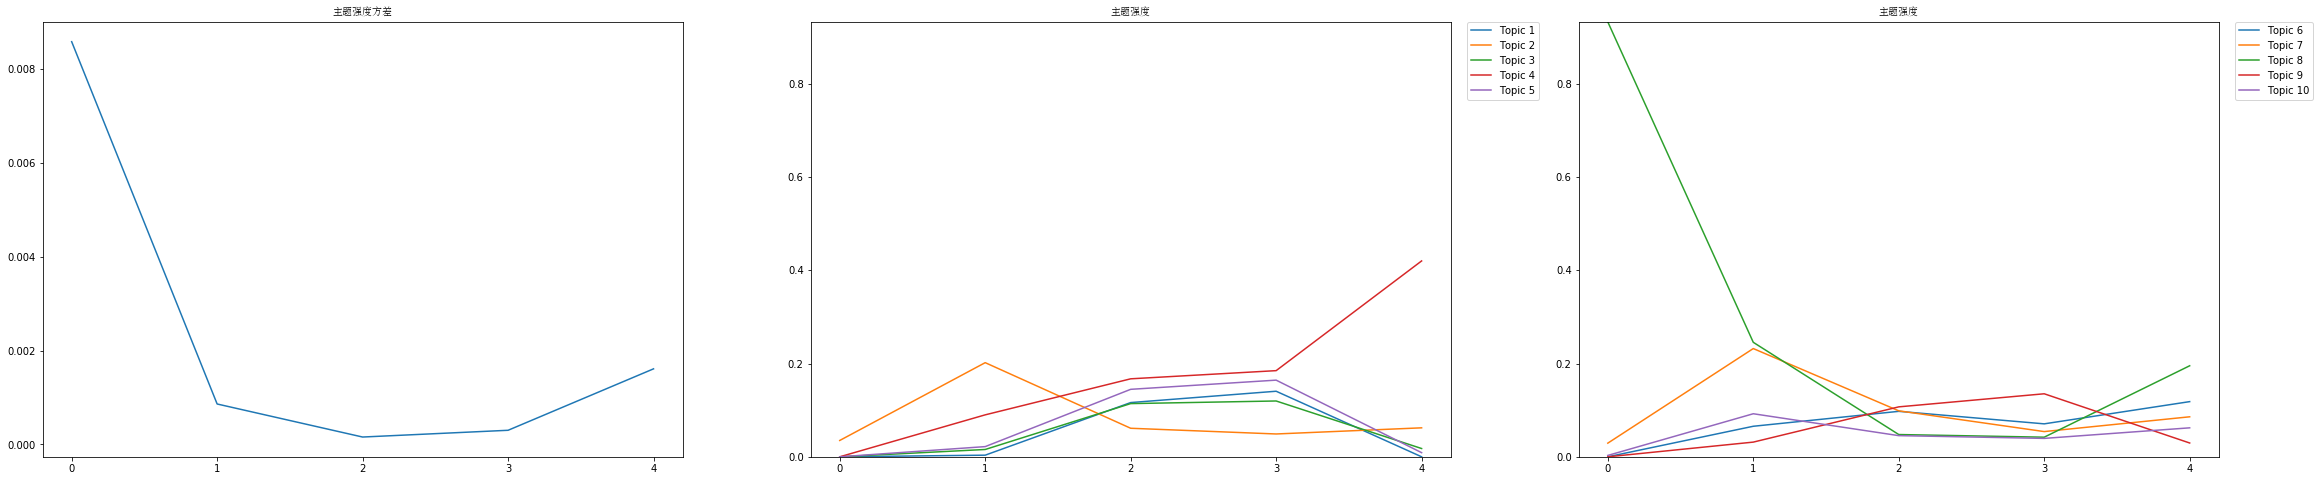

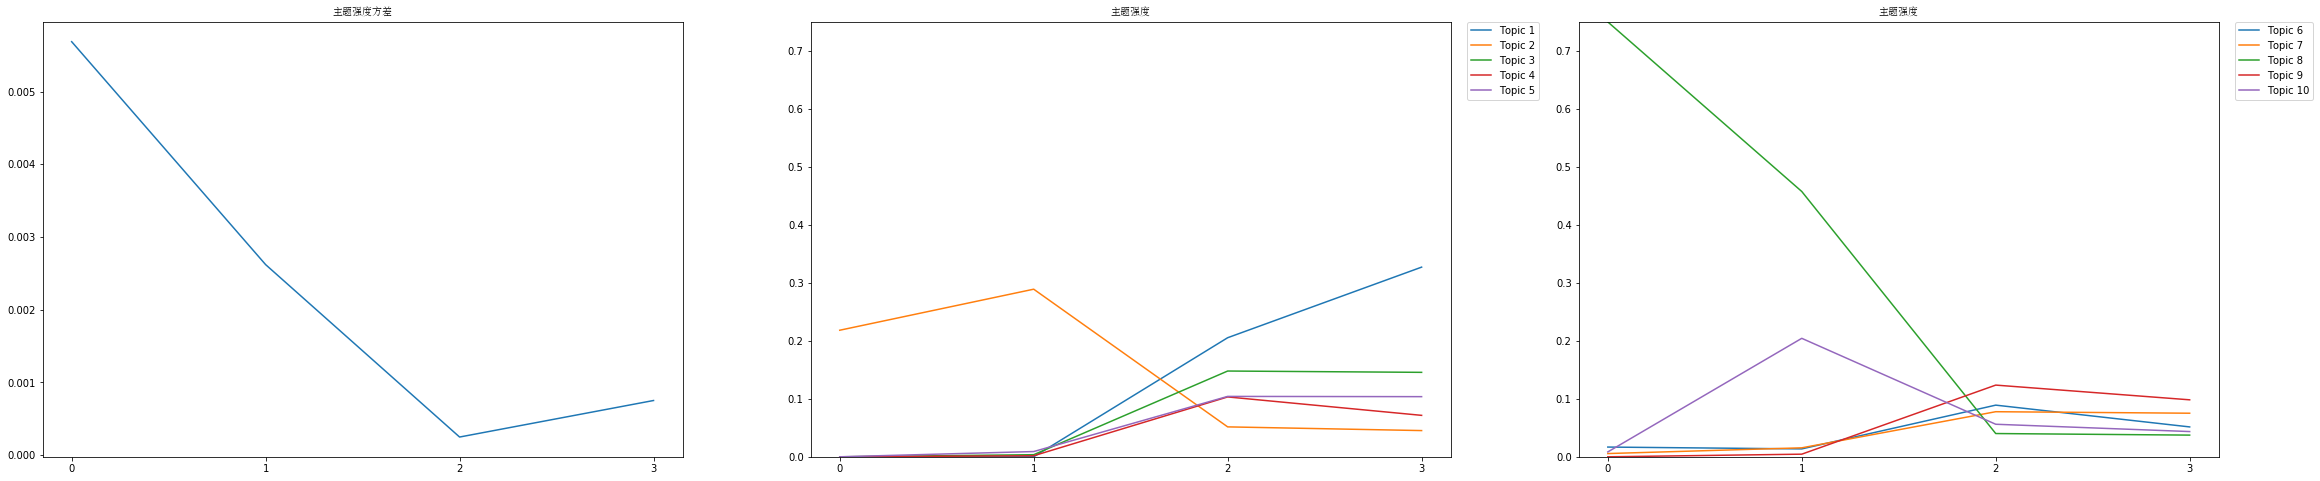

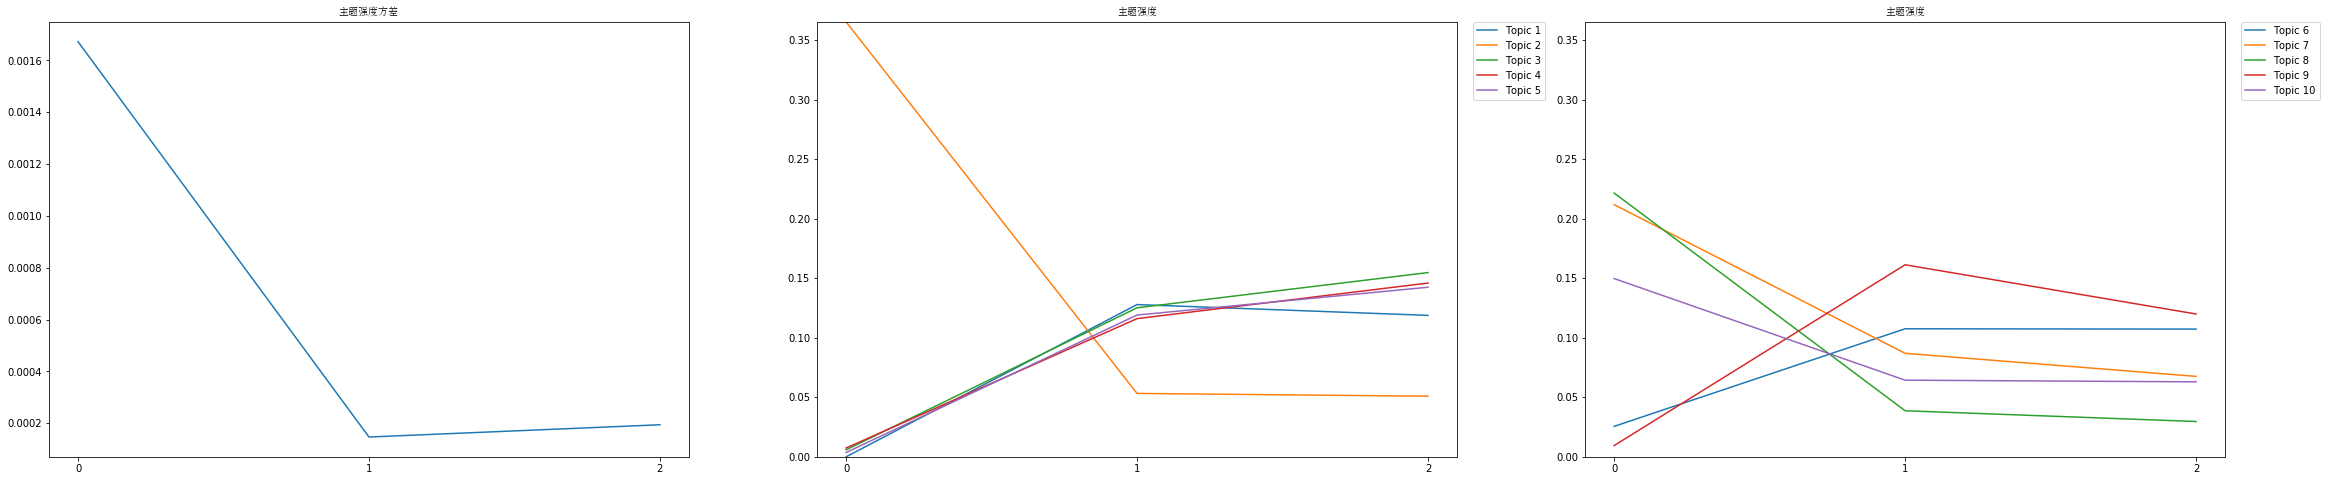

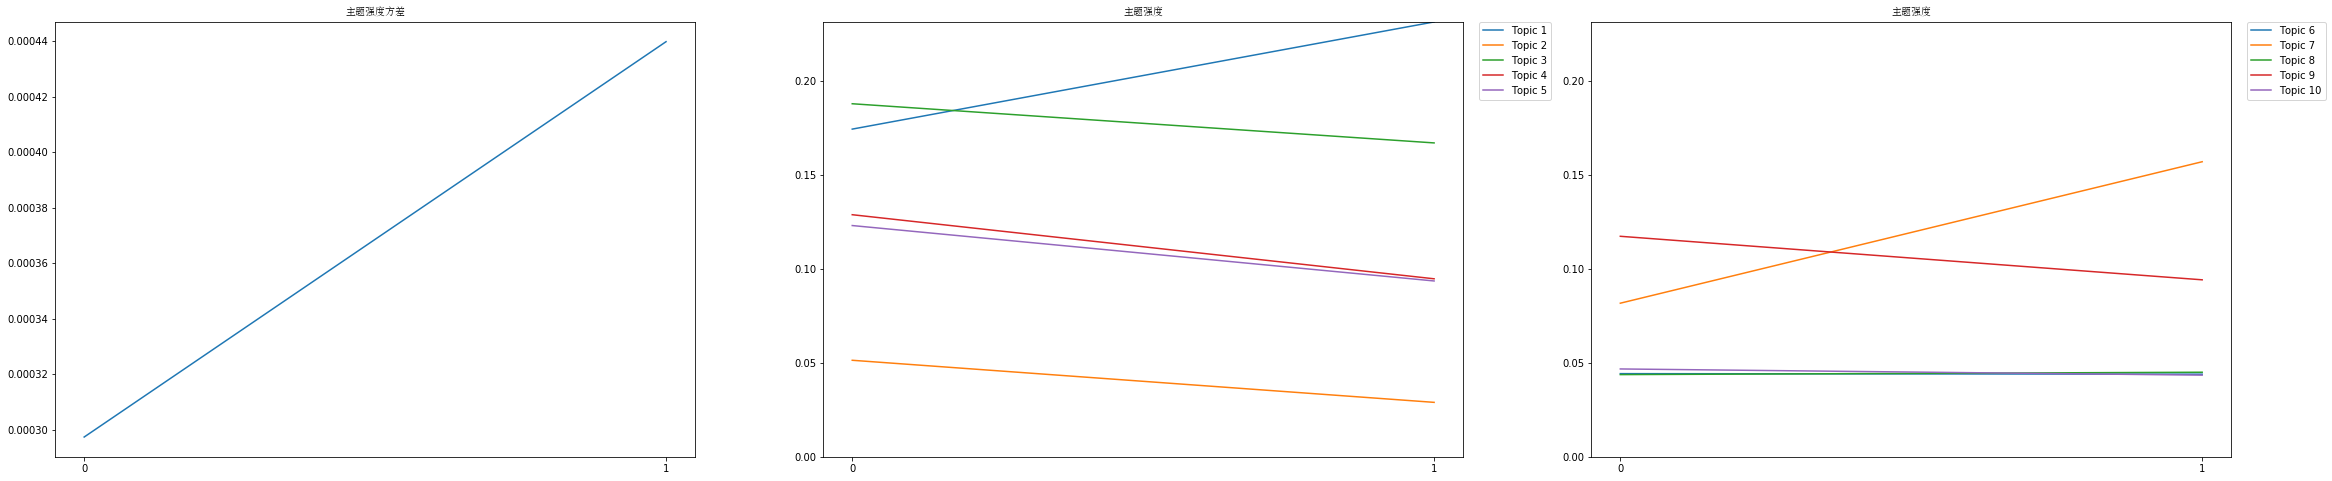

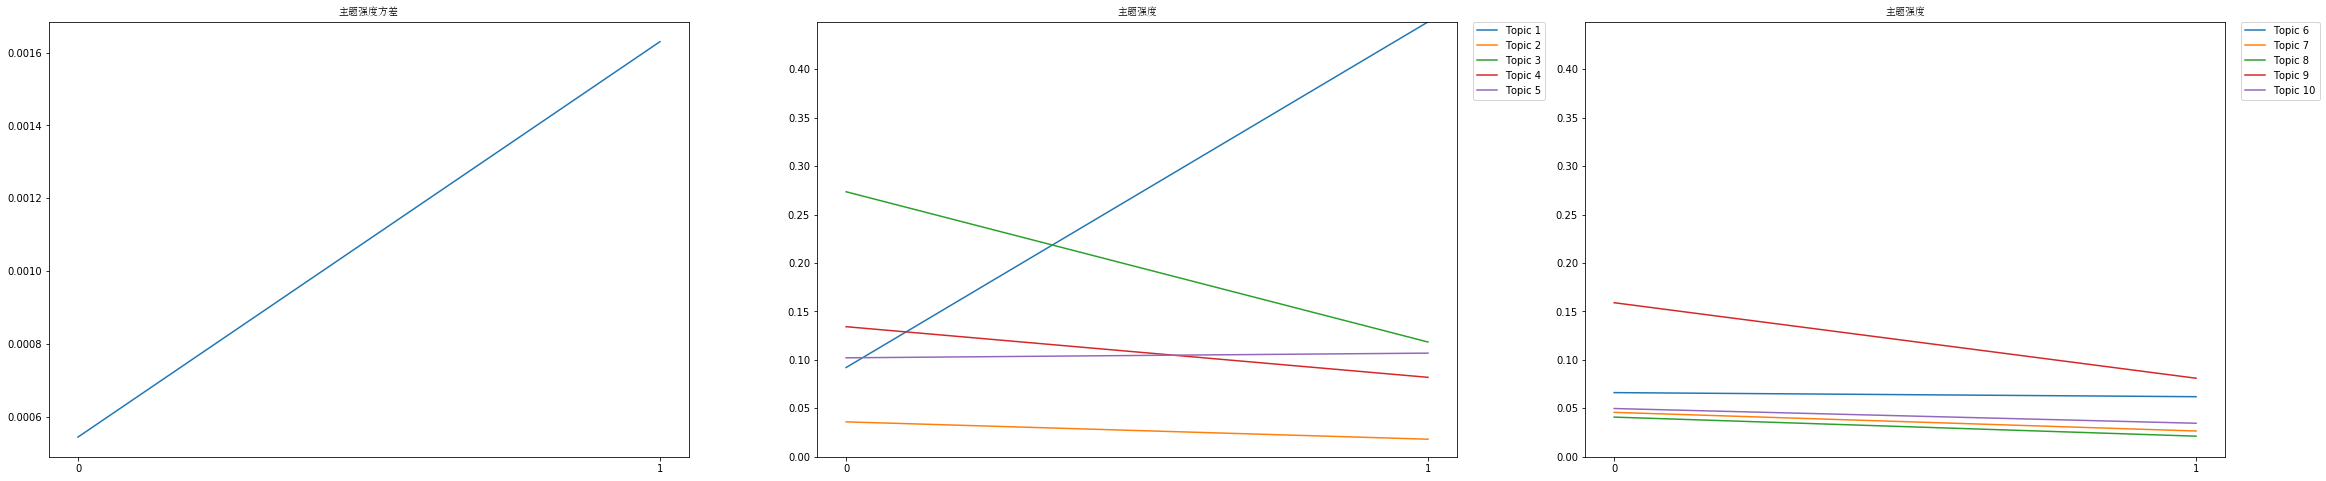

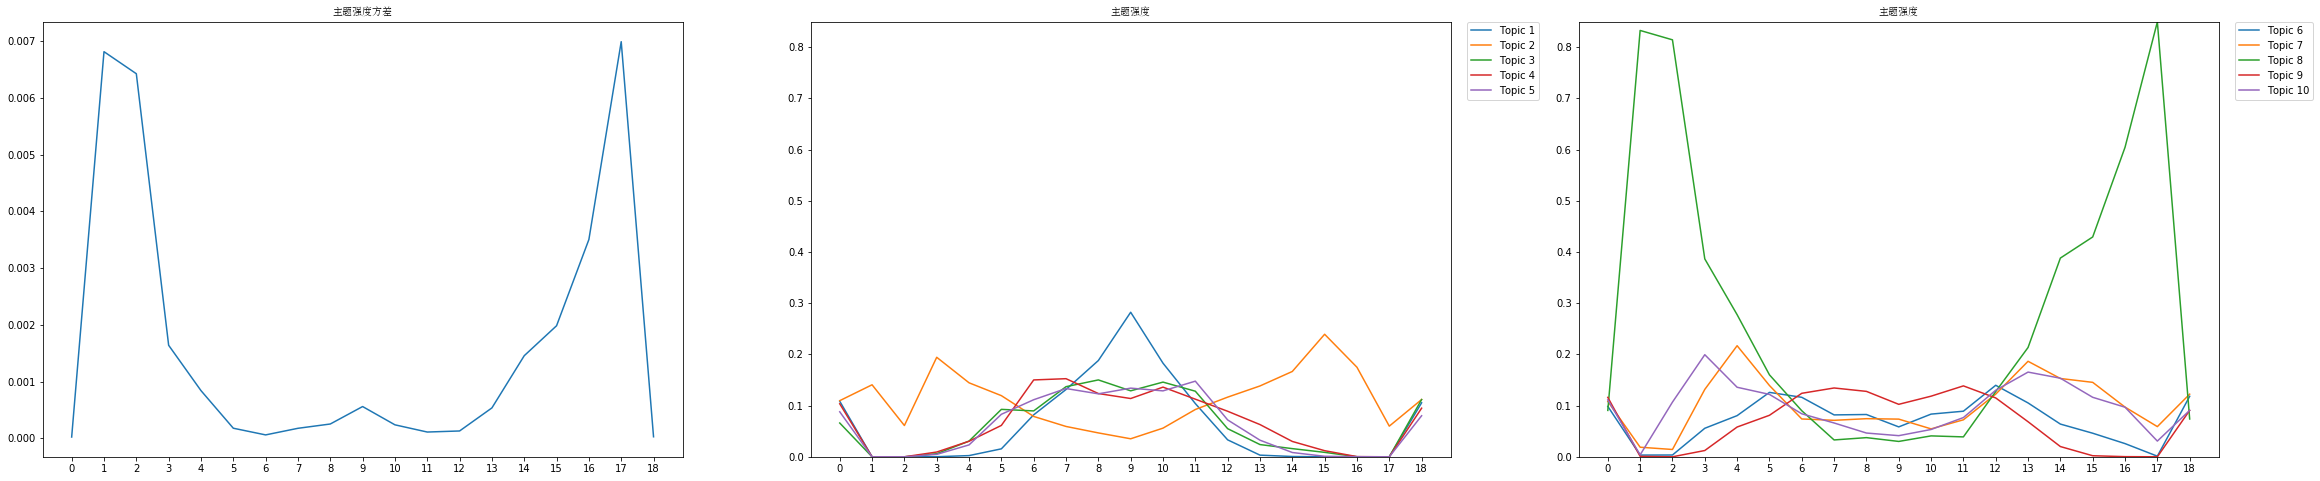

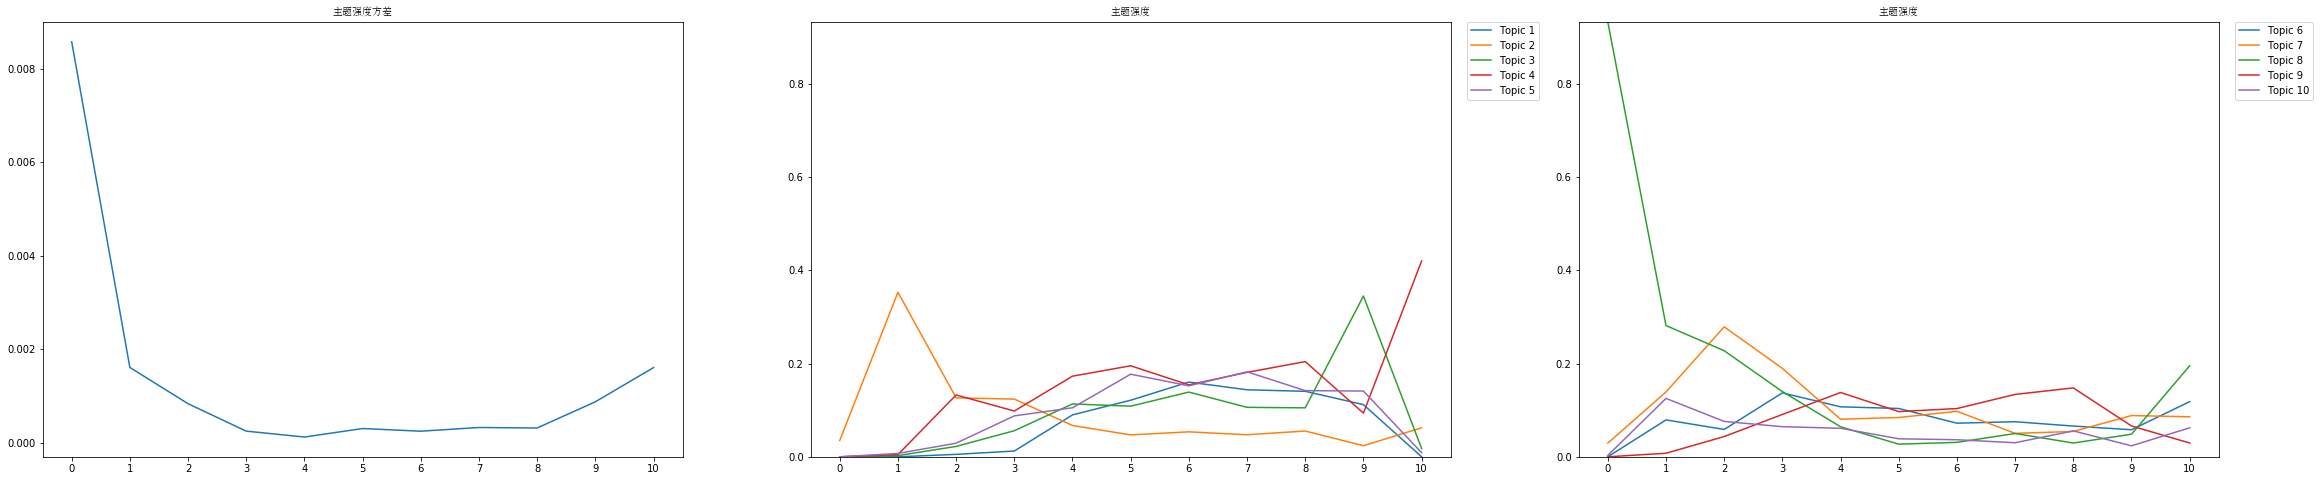

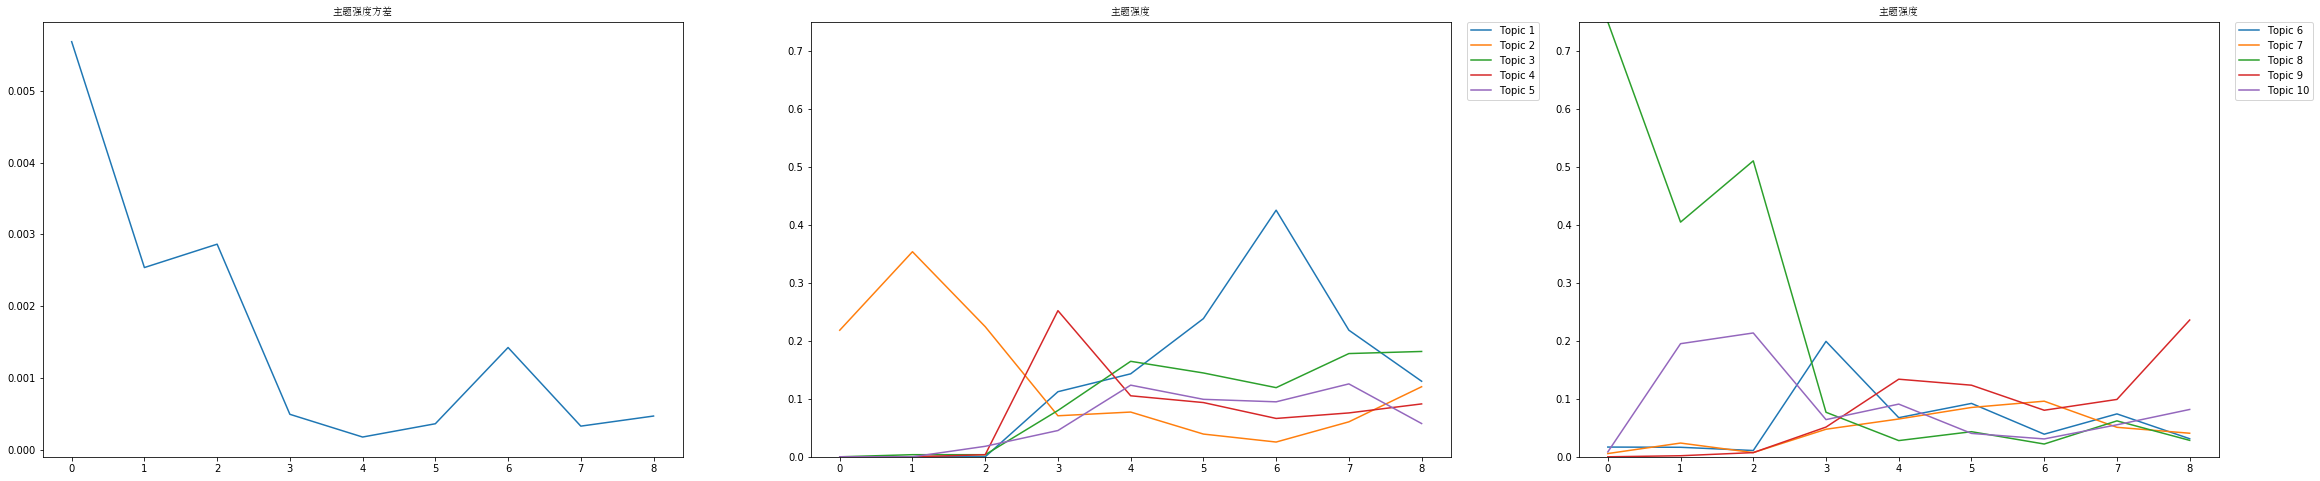

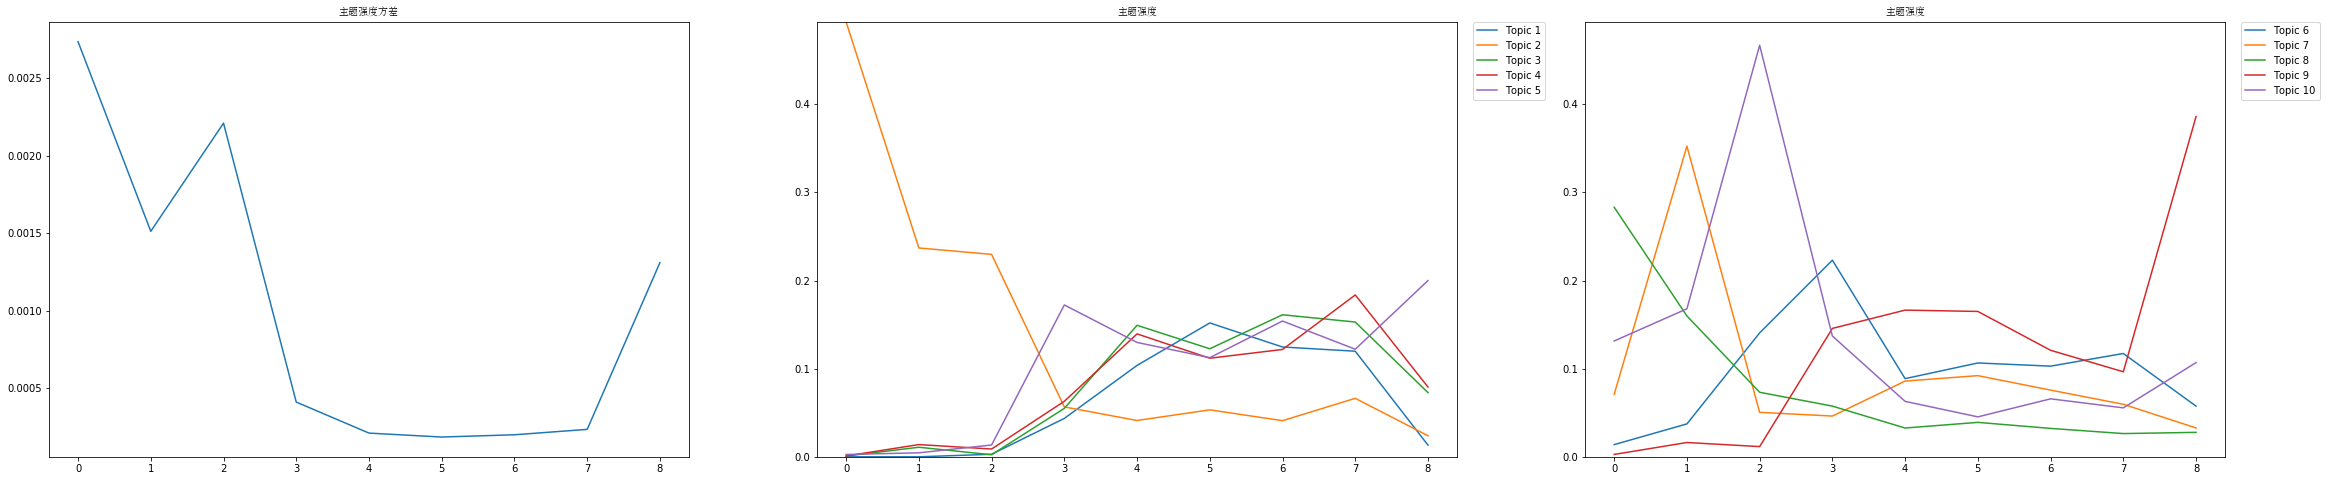

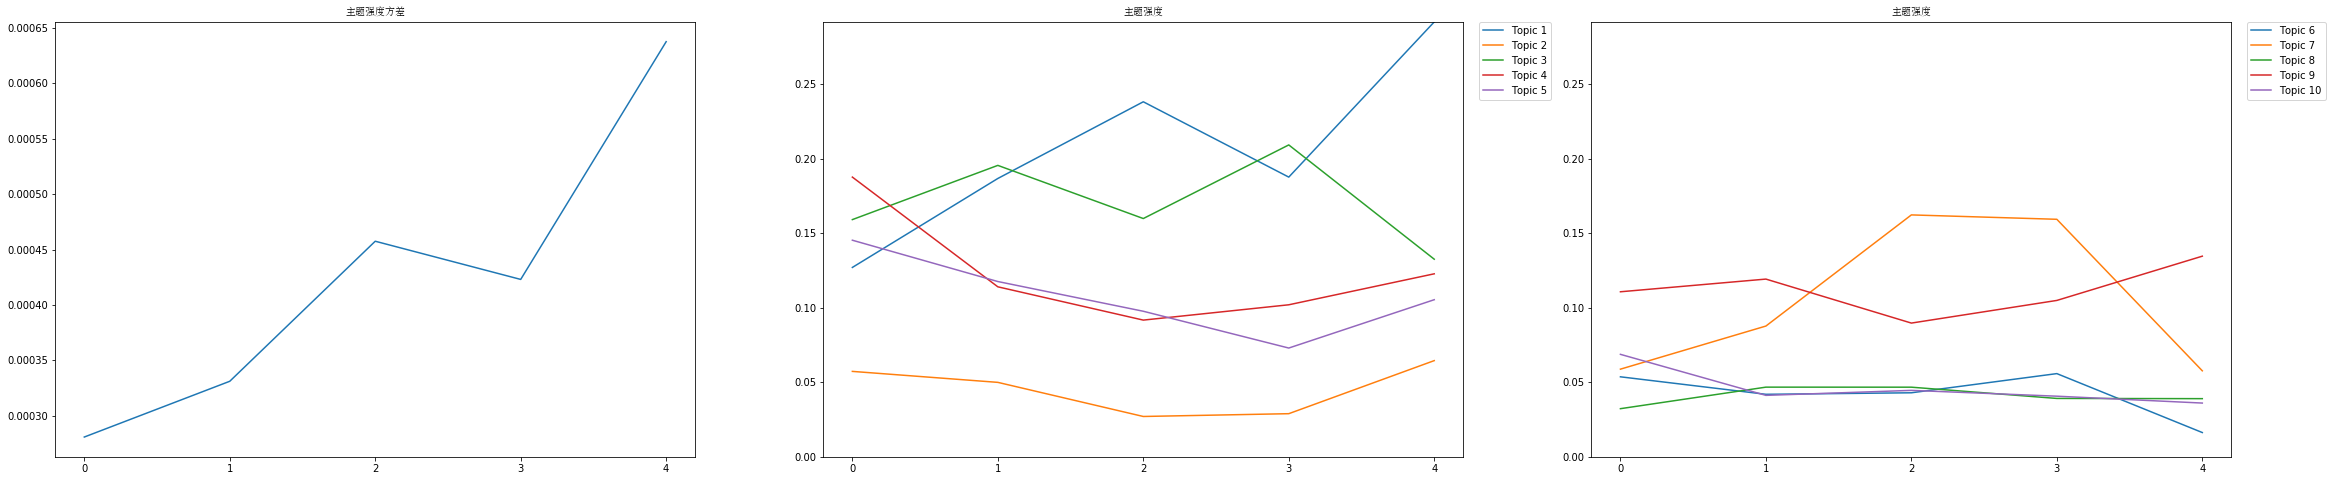

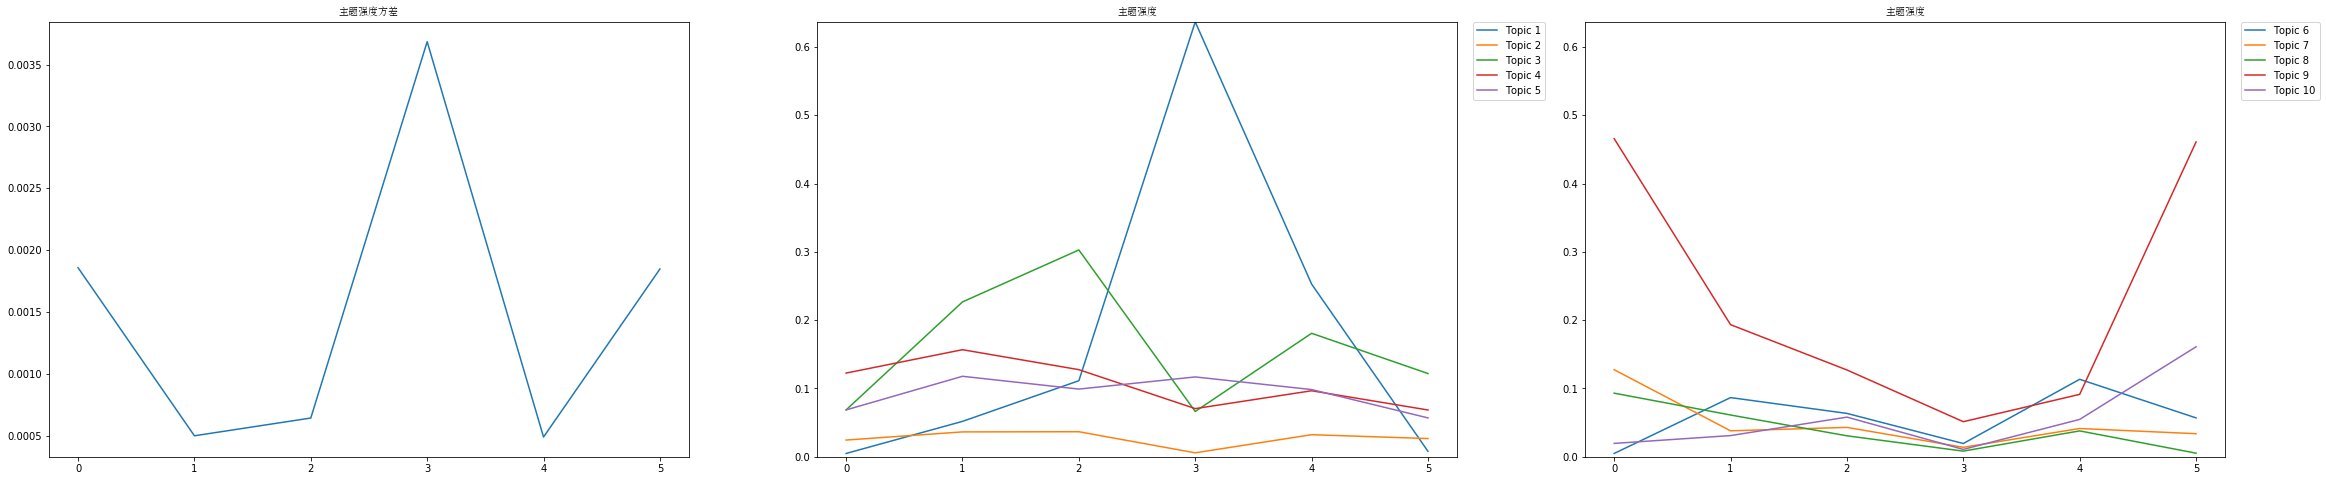

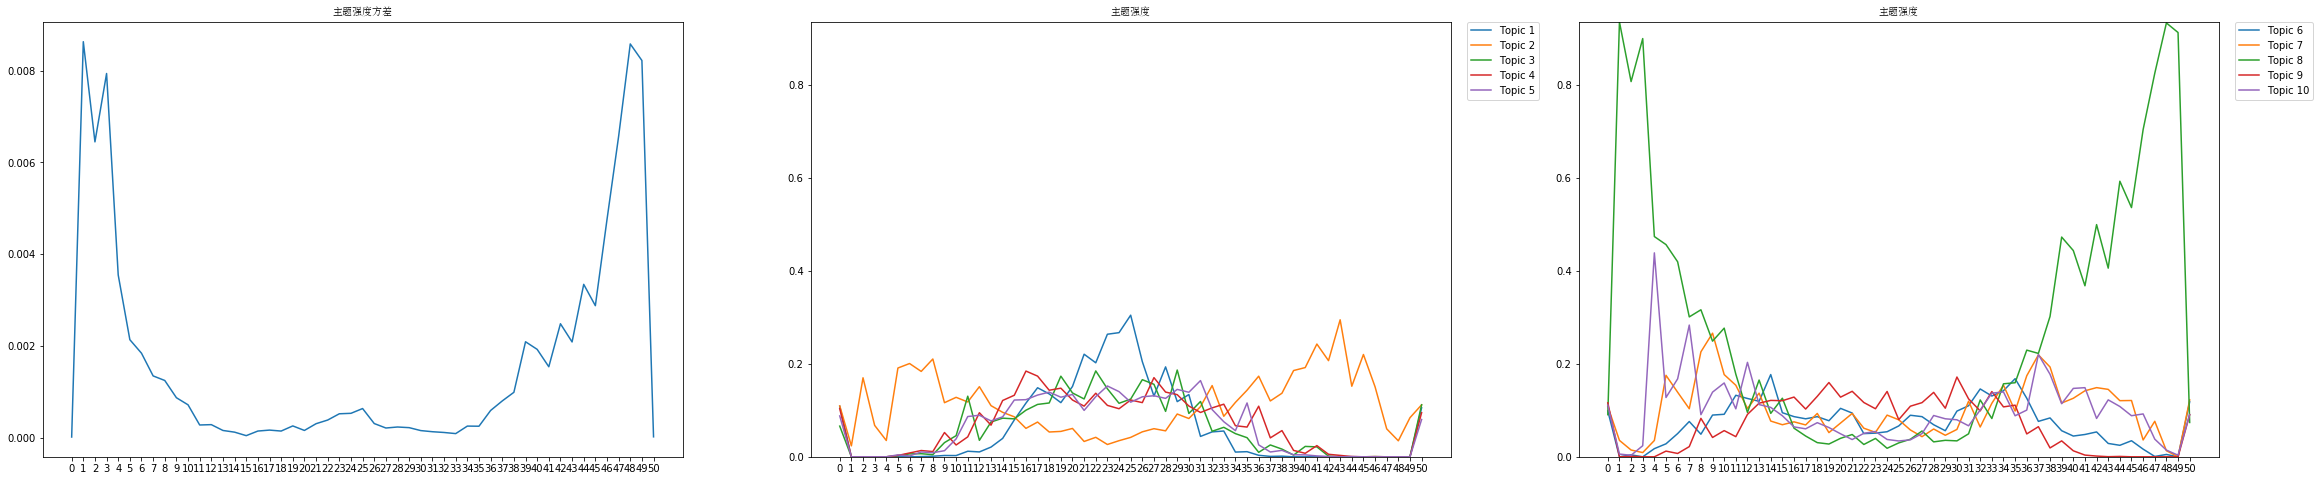

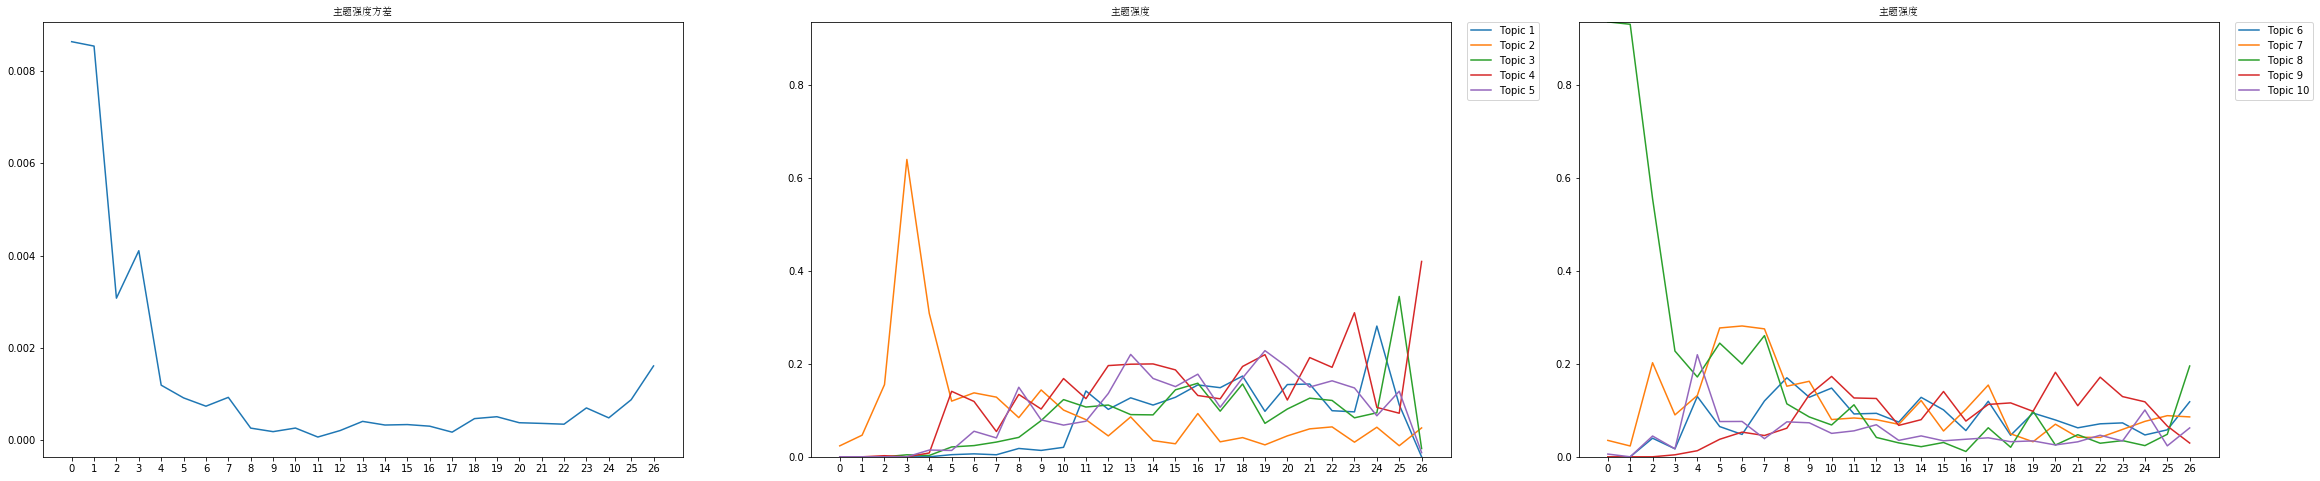

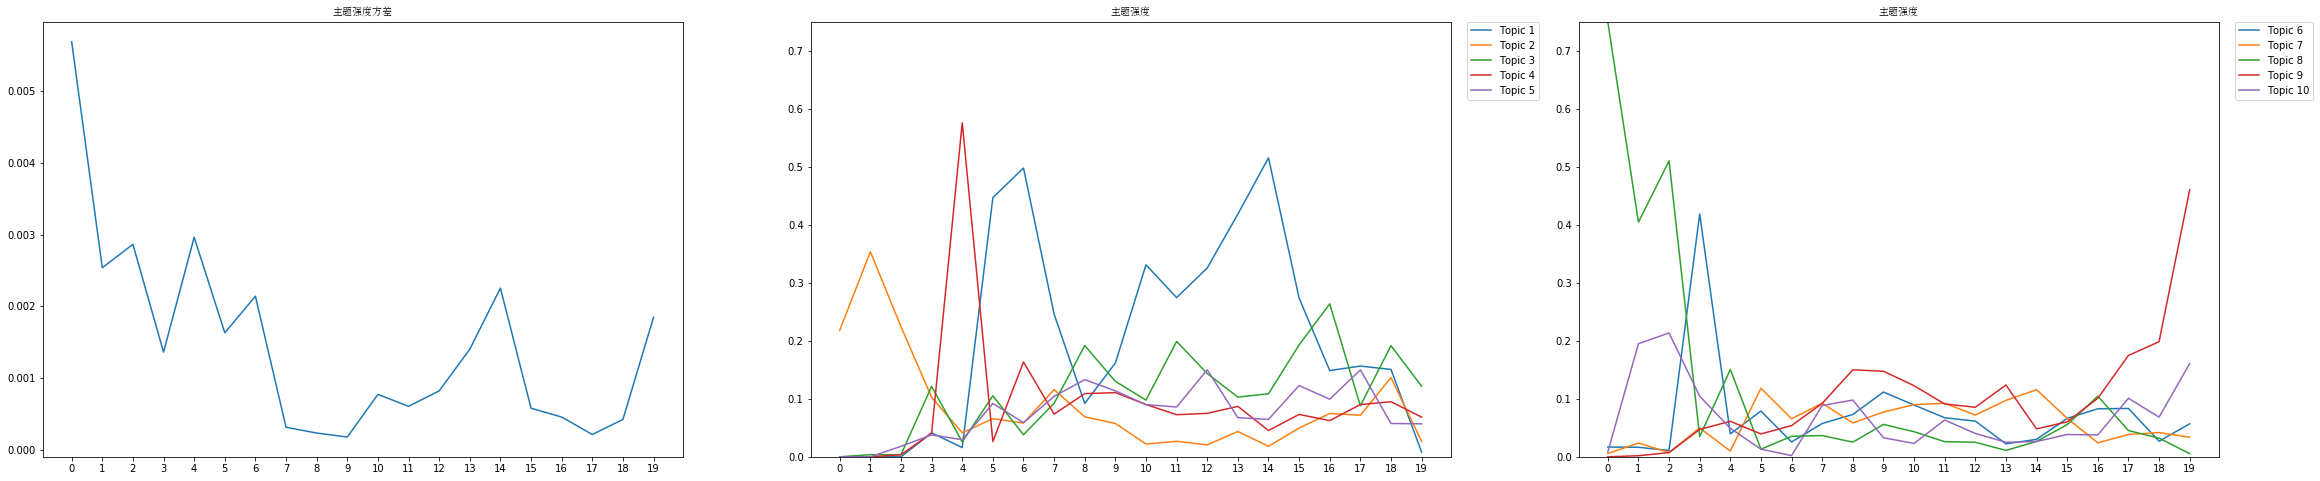

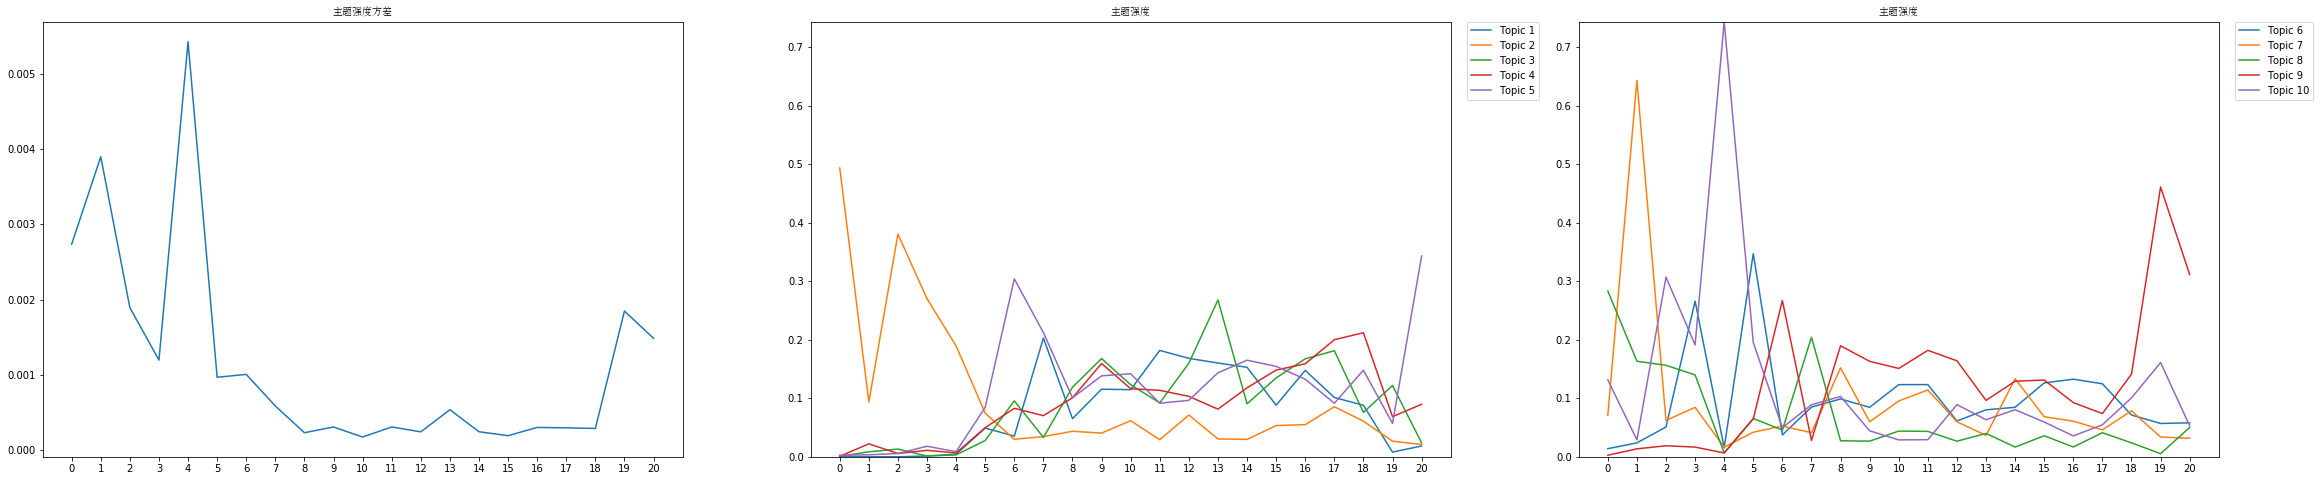

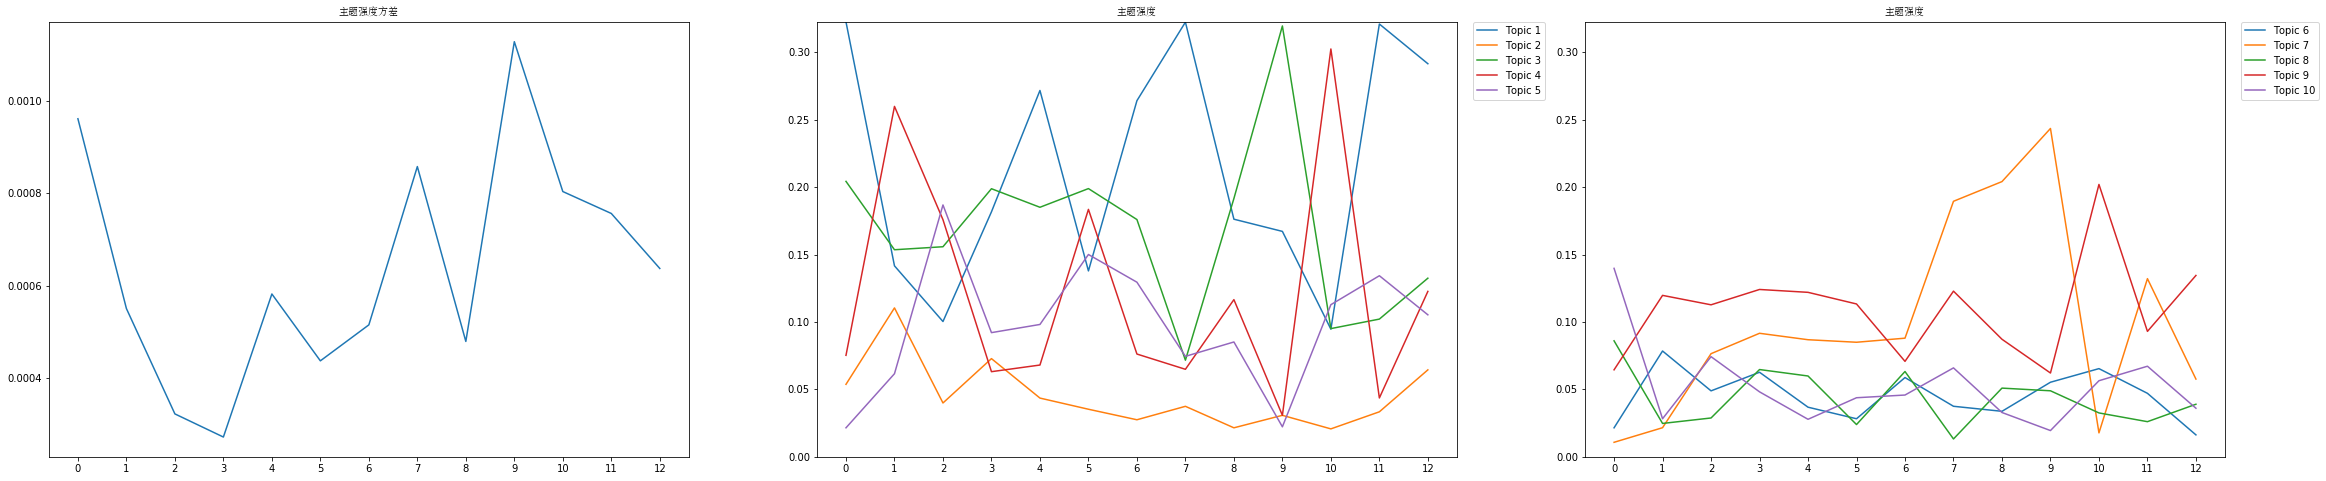

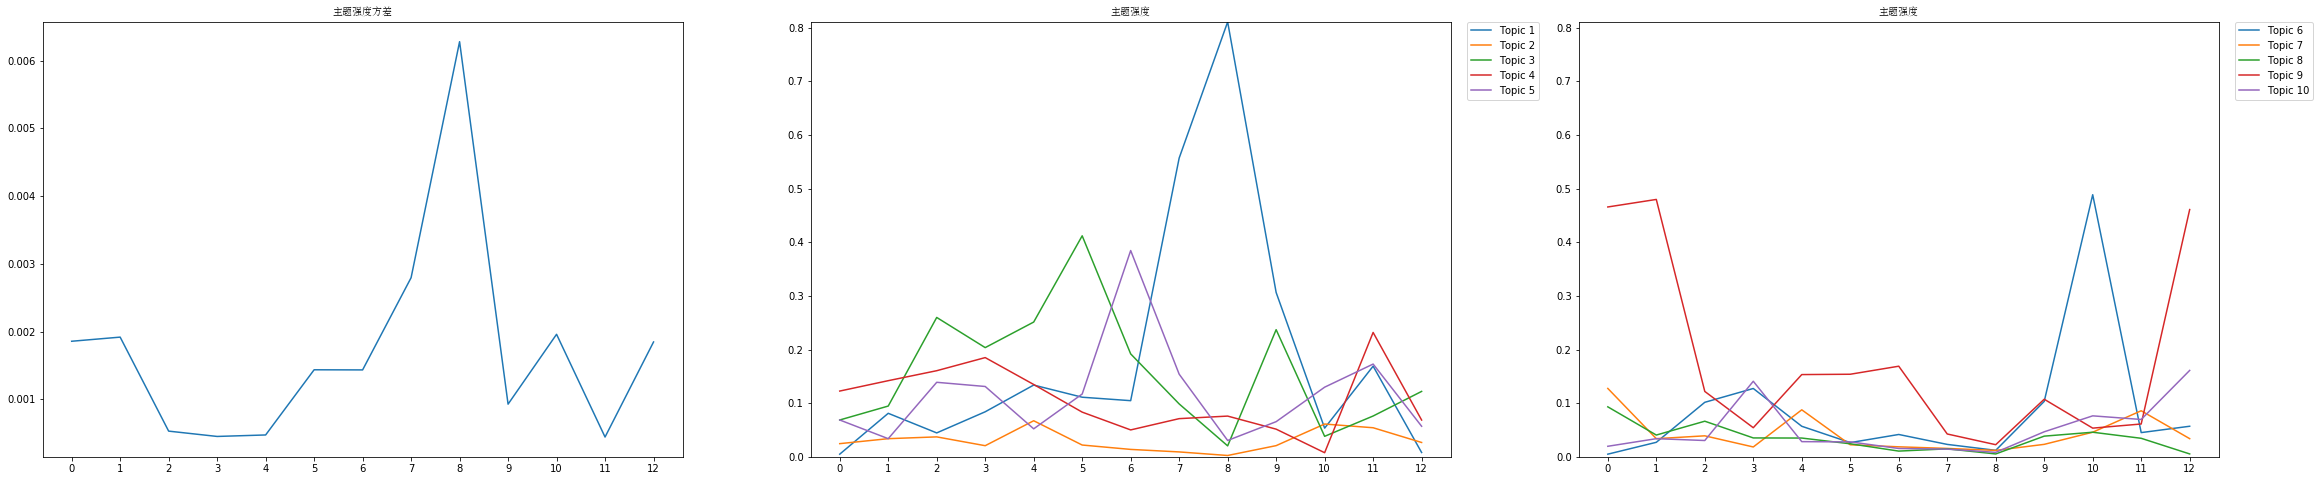

In [10]:
from MyUtils import MyUtils
import pickle
import time
##################################################################
myUtils = MyUtils()
##################################################################
filePath = outPutDir+'ZC_agro_Topics.xlsx'
if myUtils.creatBlankExcel(filePath):
    print(filePath+'  创建成功')
else:
    print(filePath+'  已存在')
#创建ExcelWriter 对象
excelWriter=myUtils.getExcelWriter(filePath)
##################################################################
PerplexityList = []
##################################################################
T_list = [10]
for T in T_list:
    ####################################################### .pickle
    tot_pickle_path = inPutDir+'tot_'+str(T)+'.pickle'
    tot_pickle = open(tot_pickle_path, 'rb')
    par = pickle.load(tot_pickle)
    print('【T='+str(T)+'】 '+par['word_token'][par['w'][1][0]])
    ####################################################### .xlsx
    Topic_words = get_Topic_words(par,20)
    myUtils.excelAddSheet(excelWriter,Topic_words,str(T)) 
    ####################################################### perplexity
    perplexity = GetPerplexity(par)
    PerplexityList.append(perplexity)
    print('【T='+str(T)+'】 perplexity = '+str(perplexity))
    #######################################################
    pngPath = outPutDir+'Topic_'+str(T)+'\\'
    if myUtils.mkdir(pngPath):
        print(pngPath+'  创建成功')
    else:
        print(pngPath+'  已存在')
    ####################################################### .png
    viz_threshold=9e-3
    VisualizeTopics(par['n'], par['word_token'], par['T'],viz_threshold, True, pngPath, 'TOT_主题_词_'+str(T))
    ####################################### 进化
    VisualizeEvolution2(par['psi'], False)
    #######################################【文档-主题】######################################
    doc_topic_pro= pd.DataFrame(par['m'])
    category = TimeAndCategory.iloc[:,-6:]
    #######################################【年】######################################
    year = pd.DataFrame(TimeAndCategory.time.apply(lambda t: time.localtime(t).tm_year))    
    data_BasYear = pd.concat([year,doc_topic_pro,category],axis=1)
    #######################################（1）全部
    # 【年】平均主题强度: 主题k在第i年的平均主题强度P_ki就是该年份内该主题下所有文档-主题强度的均值
    year_DF = data_BasYear.iloc[:,:-6].groupby(['time']).mean()
    # 【年】主题强度方差: 对于第i年，k个主题的年平均主题强度的方差
    year_DF['var'] = pd.DataFrame(year_DF.var(axis=1)/year_DF.shape[1])
    VisualizeTime2(year_DF,True,pngPath,'年_'+str(10)+'_S')
    #######################################（2）其它 5 类
    for X in data_BasYear.columns[-5:]:
        data_BasYear_X = data_BasYear[data_BasYear[X]==1]
        # 年平均主题强度: 主题k在第i年的平均主题强度P_ki就是该年份内该主题下所有文档-主题强度的均值
        year_DF_X = data_BasYear_X.iloc[:,:-6].groupby(['time']).mean()
        # 年主题强度方差: 对于第i年，k个主题的年平均主题强度的方差
        year_DF_X['var'] = pd.DataFrame(year_DF_X.var(axis=1)/year_DF_X.shape[1])
        VisualizeTime2(year_DF_X,True,pngPath,'年_'+str(T)+'_'+X)
    #######################################【年季】######################################
    yearQua = pd.DataFrame(TimeAndCategory.time.apply(lambda t: time.localtime(t).tm_year*10+(time.localtime(t).tm_mon-1)//3+1))
    data_BasYearQua = pd.concat([yearQua,doc_topic_pro,category],axis=1)
    # 【年季】平均主题强度: 主题k在第i年的平均主题强度P_ki就是该年份内该主题下所有文档-主题强度的均值
    yearQua_DF = data_BasYearQua.iloc[:,:-6].groupby(['time']).mean()
    # 【年季】主题强度方差: 对于第i年，k个主题的年平均主题强度的方差
    yearQua_DF['var'] = pd.DataFrame(yearQua_DF.var(axis=1)/yearQua_DF.shape[1])
    VisualizeTime2(yearQua_DF,True,pngPath,'年季_'+str(10)+'_S')
    #######################################（2）其它 5 类
    for X in data_BasYearQua.columns[-5:]:
        data_BasYearQua_X = data_BasYearQua[data_BasYearQua[X]==1]
        # 年平均主题强度: 主题k在第i年的平均主题强度P_ki就是该年份内该主题下所有文档-主题强度的均值
        yearQua_DF_X = data_BasYearQua_X.iloc[:,:-6].groupby(['time']).mean()
        # 年主题强度方差: 对于第i年，k个主题的年平均主题强度的方差
        yearQua_DF_X['var'] = pd.DataFrame(yearQua_DF_X.var(axis=1)/yearQua_DF_X.shape[1])
        VisualizeTime2(yearQua_DF_X,True,pngPath,'年季_'+str(T)+'_'+X)
    #######################################【年月】######################################
    yearMon = pd.DataFrame(TimeAndCategory.time.apply(lambda t: time.localtime(t).tm_year*100+time.localtime(t).tm_mon))
    data_BasYearMon = pd.concat([yearMon,doc_topic_pro,category],axis=1)
    # 【年月】平均主题强度: 主题k在第i年的平均主题强度P_ki就是该年份内该主题下所有文档-主题强度的均值
    yearMon_DF = data_BasYearMon.iloc[:,:-6].groupby(['time']).mean()
    # 【年月】主题强度方差: 对于第i年，k个主题的年平均主题强度的方差
    yearMon_DF['var'] = pd.DataFrame(yearMon_DF.var(axis=1)/yearMon_DF.shape[1])
    VisualizeTime2(yearMon_DF,True,pngPath,'年月_'+str(10)+'_S')
    #######################################（2）其它 5 类
    for X in data_BasYearMon.columns[-5:]:
        data_BasYearMon_X = data_BasYearMon[data_BasYearMon[X]==1]
        # 年平均主题强度: 主题k在第i年的平均主题强度P_ki就是该年份内该主题下所有文档-主题强度的均值
        yearMon_DF_X = data_BasYearMon_X.iloc[:,:-6].groupby(['time']).mean()
        # 年主题强度方差: 对于第i年，k个主题的年平均主题强度的方差
        yearMon_DF_X['var'] = pd.DataFrame(yearMon_DF_X.var(axis=1)/yearMon_DF_X.shape[1])
        VisualizeTime2(yearMon_DF_X,True,pngPath,'年月_'+str(T)+'_'+X)
    




In [11]:
# import time
# timeArray = time.localtime(data.time[0])
# print(timeArray)
# #转换为时间戳:
# timeStamp = int(time.mktime(timeArray))
# print(timeStamp)